# Churn Prediction


In [2]:
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

sns.set(rc={'figure.figsize':(8,6)})

from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

plt.figure(figsize=(20, 10))

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

### Reading / Loading the Raw Data into Python from SQL

In [10]:
import pypyodbc as podbc

conn2 = podbc.connect("Driver={ODBC Driver 18 for SQL Server};"
                     "Server=DESKTOP-MMC9PLC\SQLEXPRESS01;"
                     "Database=Churns Predict;"
                     "Trusted_Connection=yes;"
                     "Encrypt=yes;"
                     "TrustServerCertificate=yes;")

SQL_Query = pd.read_sql_query('''SELECT * FROM [dbo].[churn raw data]''', conn2)

print(SQL_Query.shape)

SQL_Query.head()

(10000, 14)


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0


In [12]:
for column in SQL_Query:
    unique_vals = np.unique(SQL_Query[column])
    nr_values = len(unique_vals)
    if nr_values < 12:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature rownumber :10000
The number of values for feature customerid :10000
The number of values for feature surname :2932
The number of values for feature creditscore :460
The number of values for feature geography :3 -- ['France' 'Germany' 'Spain']
The number of values for feature gender :2 -- ['Female' 'Male']
The number of values for feature age :70
The number of values for feature tenure :11 -- ['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']
The number of values for feature balance :6382
The number of values for feature numofproducts :4 -- ['1' '2' '3' '4']
The number of values for feature hascrcard :2 -- ['0' '1']
The number of values for feature isactivemember :2 -- ['0' '1']
The number of values for feature estimatedsalary :9999
The number of values for feature exited :2 -- ['0' '1']


In [18]:
SQL_Query.isnull().sum()

rownumber          0
customerid         0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [22]:
raw_data = SQL_Query.rename(columns={
    'creditscore': 'CreditScore',
    'geography': 'Geography',
    'gender': 'Gender',
    'age': 'Age',
    'tenure': 'Tenure',
    'balance': 'Balance',
    'numofproducts': 'NumOfProducts',
    'hascrcard': 'HasCrCard',
    'isactivemember': 'IsActiveMember',
    'estimatedsalary': 'EstimatedSalary',
    'exited': 'Exited'
})

raw_data2 = raw_data[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]


In [23]:
raw_data2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,699,France,Female,39,1,0,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0


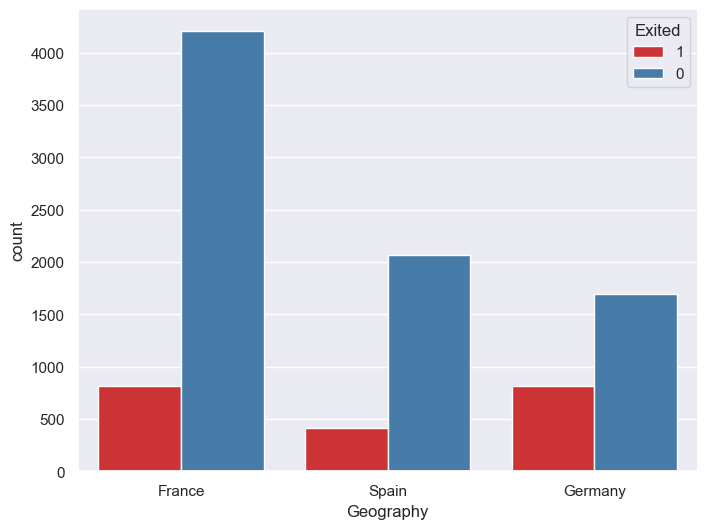

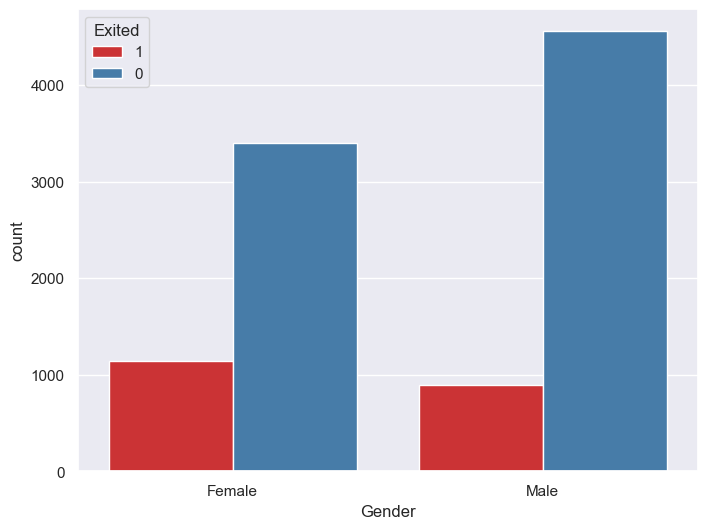

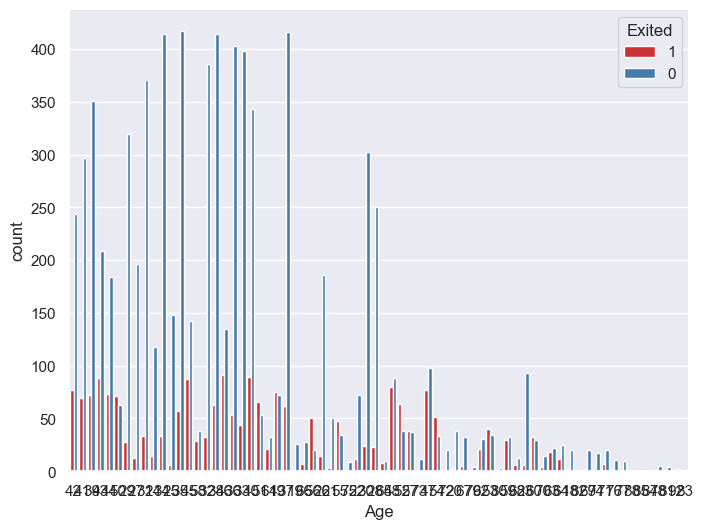

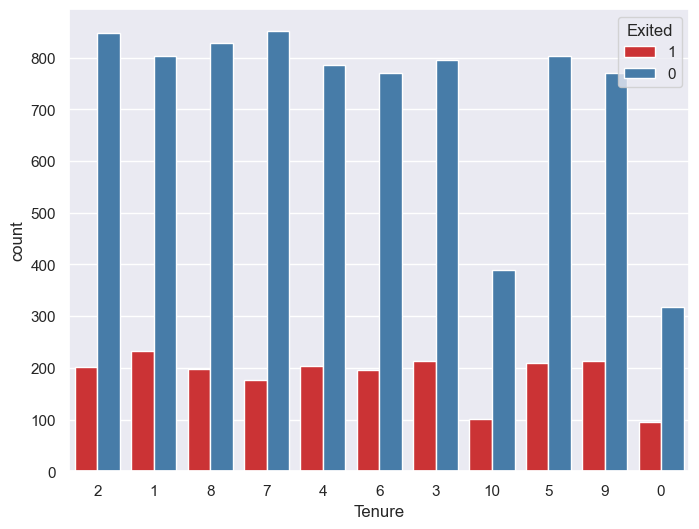

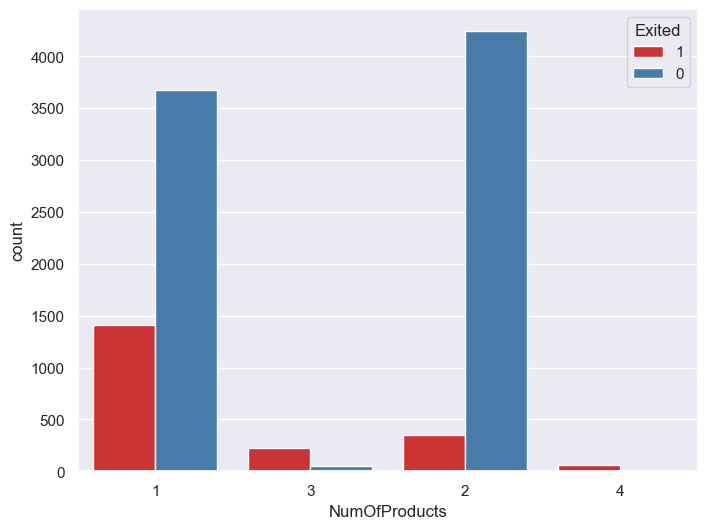

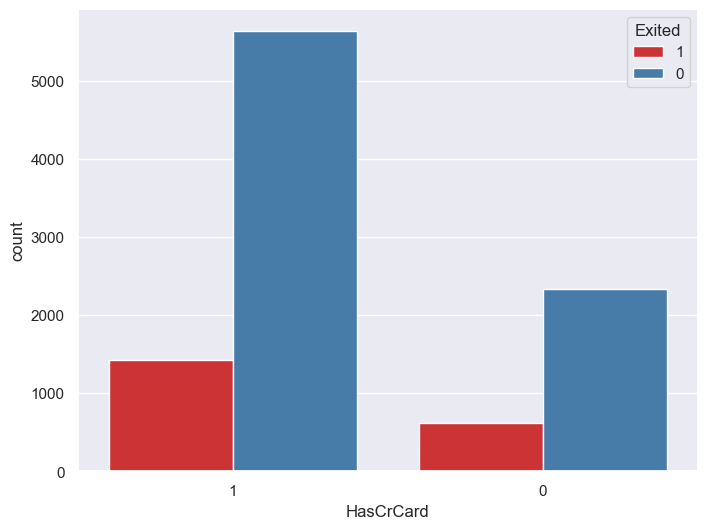

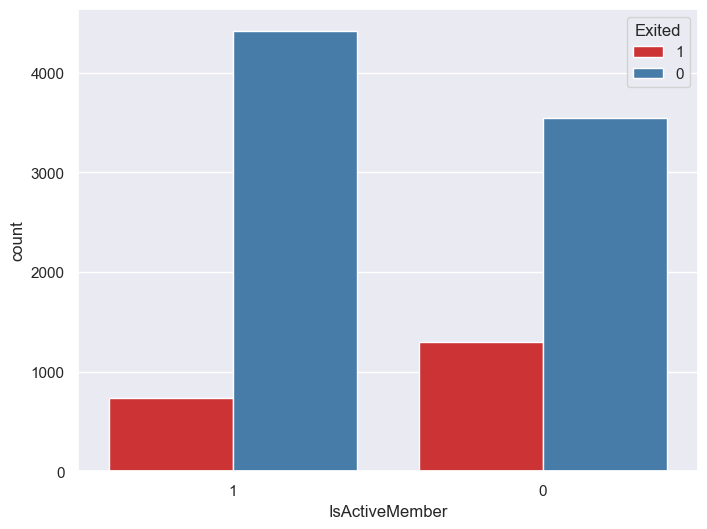

In [24]:
features = ['Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

for f in features:
    plt.figure()
    ax = sns.countplot(x=f, data=raw_data, hue = 'Exited', palette="Set1")

In [25]:
# making categorical variables into numeric representation

new_raw_data = pd.get_dummies(raw_data2, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'])
new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0,1,101348.88,1,True,False,False,True,False,False,True,False,True
1,608,41,1,83807.86,1,112542.58,0,False,False,True,True,False,True,False,False,True
2,502,42,8,159660.8,3,113931.57,1,True,False,False,True,False,False,True,True,False
3,699,39,1,0,2,93826.63,0,True,False,False,True,False,True,False,True,False
4,850,43,2,125510.82,1,79084.1,0,False,False,True,True,False,False,True,False,True


In [26]:
new_raw_data['Balance'].max()

'99986.98'

In [27]:
# Scaling columns

scale_vars = ['CreditScore','EstimatedSalary','Balance','Age']
scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars])
new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,True,False,False,True,False,False,True,False,True
1,0.516,0.310811,1,0.334031,1,0.562709,0,False,False,True,True,False,True,False,False,True
2,0.304,0.324324,8,0.636357,3,0.569654,1,True,False,False,True,False,False,True,True,False
3,0.698,0.283784,1,0.000000,2,0.469120,0,True,False,False,True,False,True,False,True,False
4,1.000,0.337838,2,0.500246,1,0.395400,0,False,False,True,True,False,False,True,False,True


### Hold-out validation

In [28]:
X = new_raw_data.drop('Exited', axis=1).values
y = new_raw_data['Exited'].values 
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

X shape: (10000, 15)
y shape: (10000,)


### Running Decision Tree

In [29]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

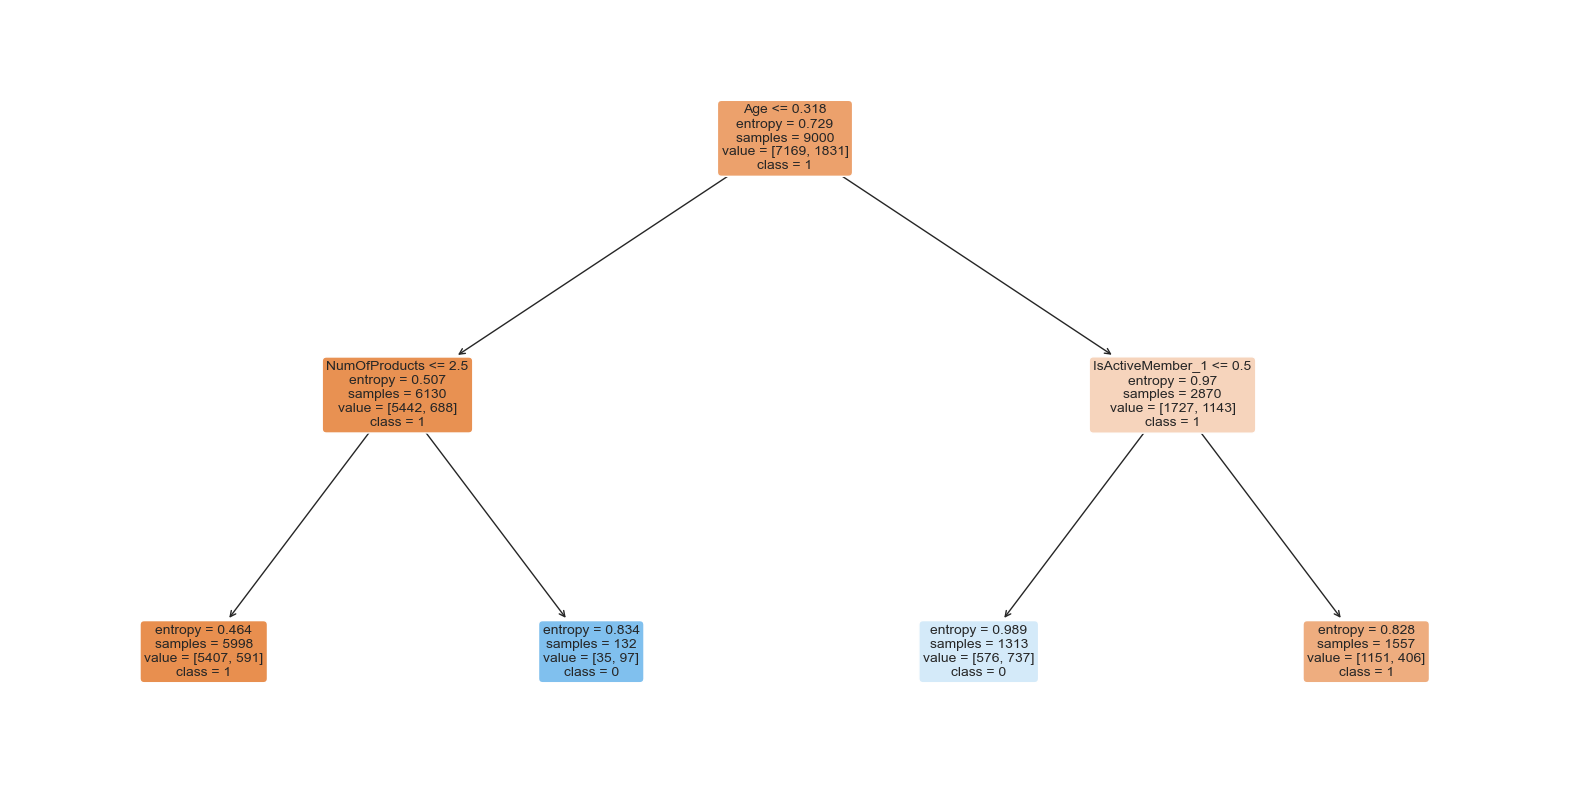

In [39]:

plot_tree(dt, 
          feature_names=new_raw_data.drop('Exited', axis=1).columns, 
          class_names=new_raw_data['Exited'].unique().astype(str), 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.show()


In [40]:
for i, column in enumerate(new_raw_data.drop('Exited', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi
        
final_fi = final_fi.sort_values('Feature Importance Score', ascending = False).reset_index()            
final_fi

Importance of feature CreditScore:, 0.000
Importance of feature Age:, 0.622
Importance of feature Tenure:, 0.000
Importance of feature Balance:, 0.000
Importance of feature NumOfProducts:, 0.196
Importance of feature EstimatedSalary:, 0.000
Importance of feature Geography_France:, 0.000
Importance of feature Geography_Germany:, 0.000
Importance of feature Geography_Spain:, 0.000
Importance of feature Gender_Female:, 0.000
Importance of feature Gender_Male:, 0.000
Importance of feature HasCrCard_0:, 0.000
Importance of feature HasCrCard_1:, 0.000
Importance of feature IsActiveMember_0:, 0.000
Importance of feature IsActiveMember_1:, 0.182


,index,Variable,Feature Importance Score
0,1,Age,0.622346
1,4,NumOfProducts,0.195552
2,14,IsActiveMember_1,0.182102
3,0,CreditScore,0.000000
4,2,Tenure,0.000000
5,3,Balance,0.000000
6,5,EstimatedSalary,0.000000
7,6,Geography_France,0.000000
8,7,Geography_Germany,0.000000
9,8,Geography_Spain,0.000000


In [41]:
print("Training Accuracy is: ", dt.score(X_train, y_train))

print("Testing Accuracy is: ", dt.score(X_test, y_test))

Training Accuracy is:  0.8213333333333334
Testing Accuracy is:  0.822


In [45]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

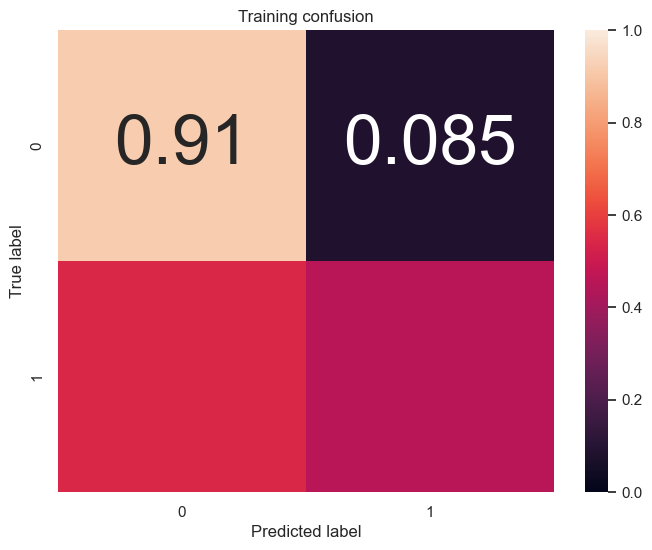

In [46]:
y_pred = dt.predict(X_train)

cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [47]:
y_pred = dt.predict(X_train)
y_pred
confusion_matrix(y_train, y_pred)

array([[6558,  611],
       [ 997,  834]], dtype=int64)

In [48]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2)

The True Positive rate / Recall per class is:  [0.914772 0.455489]
The Precision per class is:  [0.868034 0.577163]
The False Alarm rate per class is:  [0.544511 0.085228]
The Miss Rate rate per class is:  [0.085228 0.544511]
The Classification error of each class is [0.178667 0.178667]
The Accuracy of each class is [0.821333 0.821333]

The average Recall is:  0.685130369325603
The average Precision is:  0.7225985220264771
The average False Alarm is:  0.31486963067439694
The average Miss Rate rate is:  0.31486963067439694
The average Classification error is 0.17866666666666667
The average Accuracy is 0.8213333333333334


### Running Random Forest

Training Accuracy is:  1.0
Testing Accuracy is:  0.865


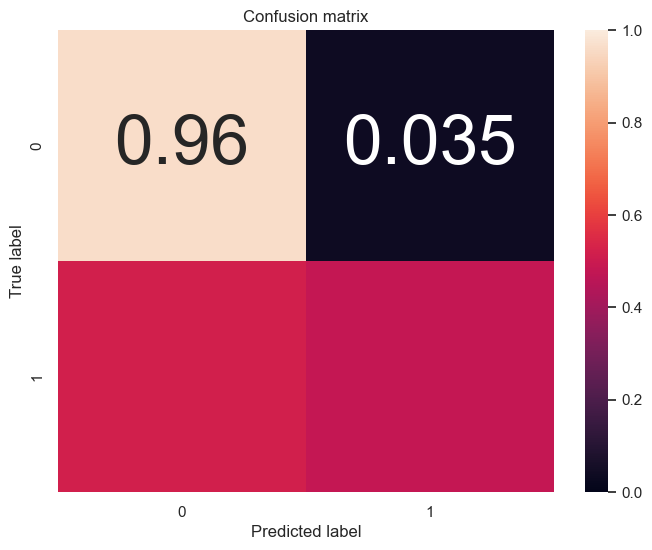

In [49]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

print("Training Accuracy is: ", rf.score(X_train, y_train))

print("Testing Accuracy is: ", rf.score(X_test, y_test))

cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.860
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.797
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.802
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.868
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.800
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.812
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.831
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.850
Classification accuracy on test set with max features = log2 and max_depth = None: 0.868
Classification accuracy on test set with max features = log2

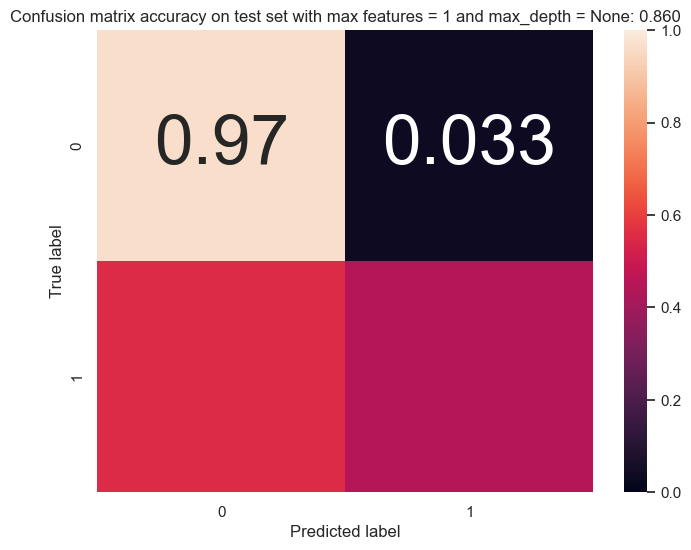

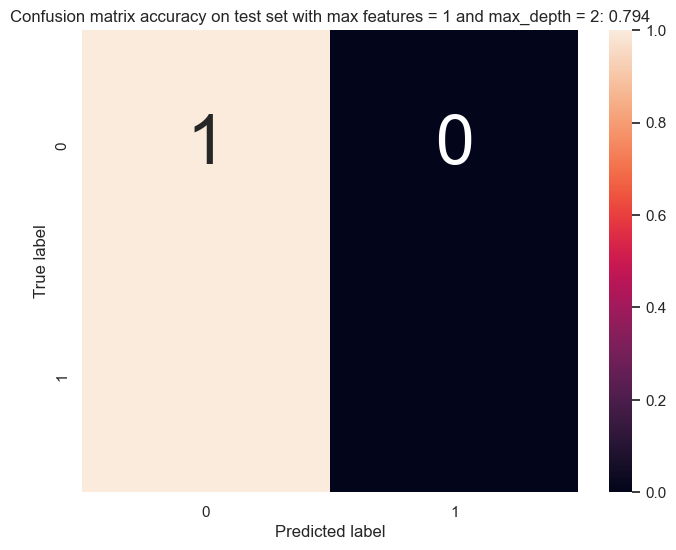

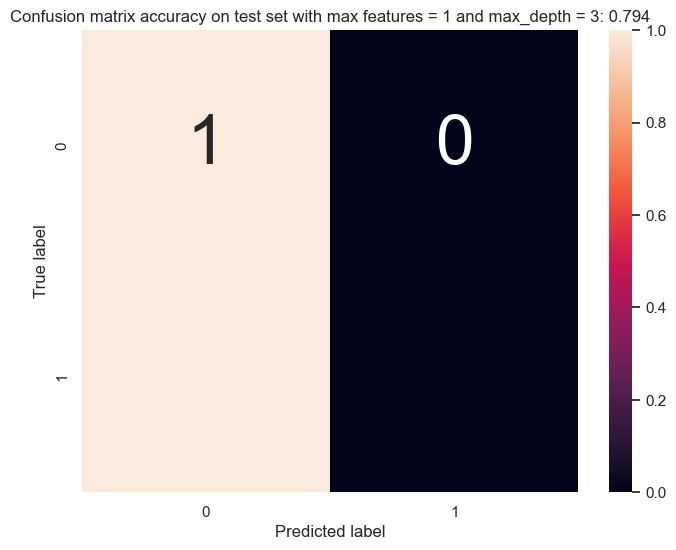

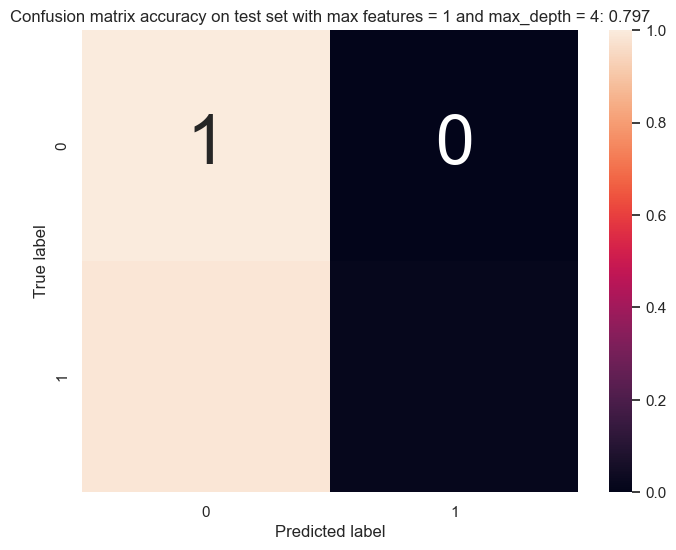

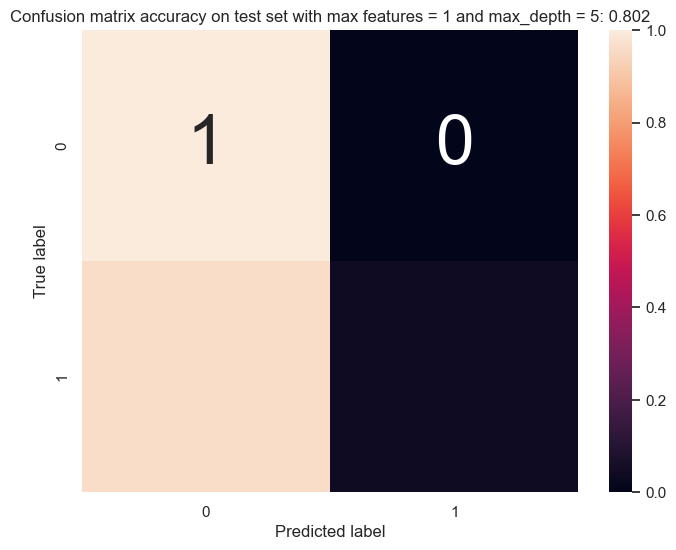

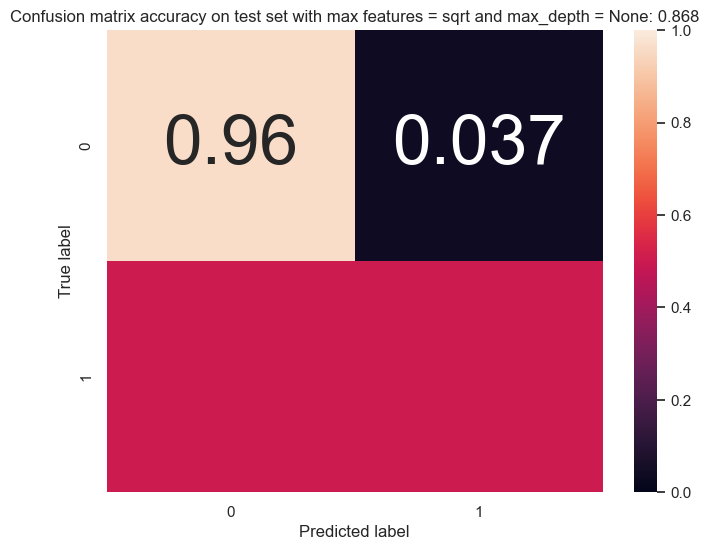

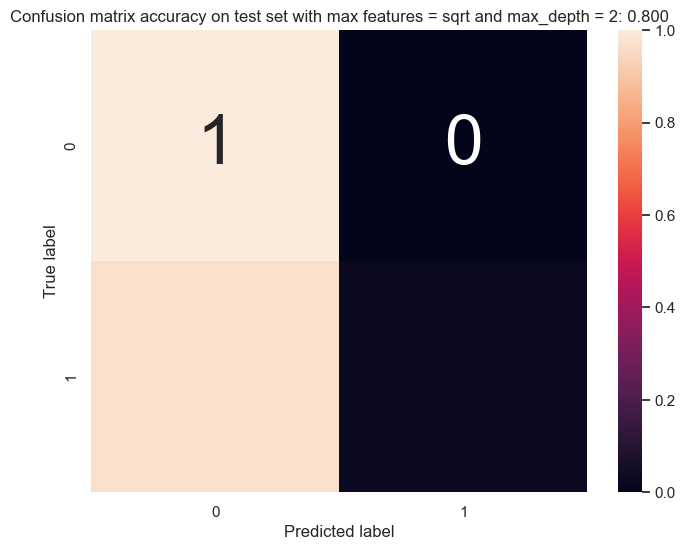

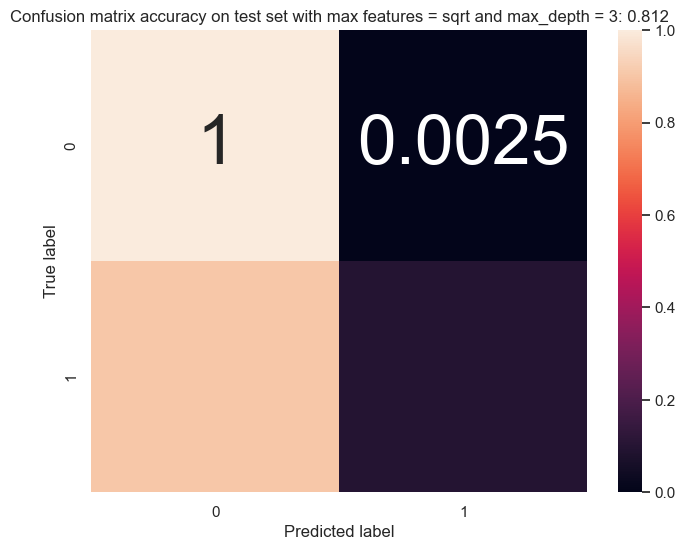

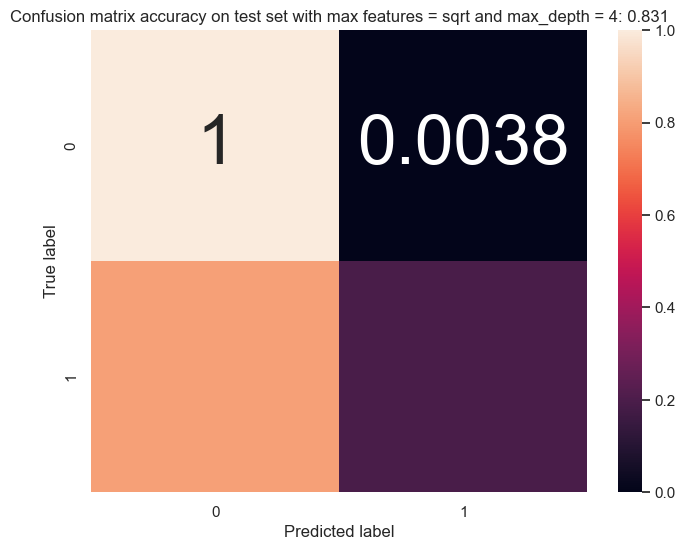

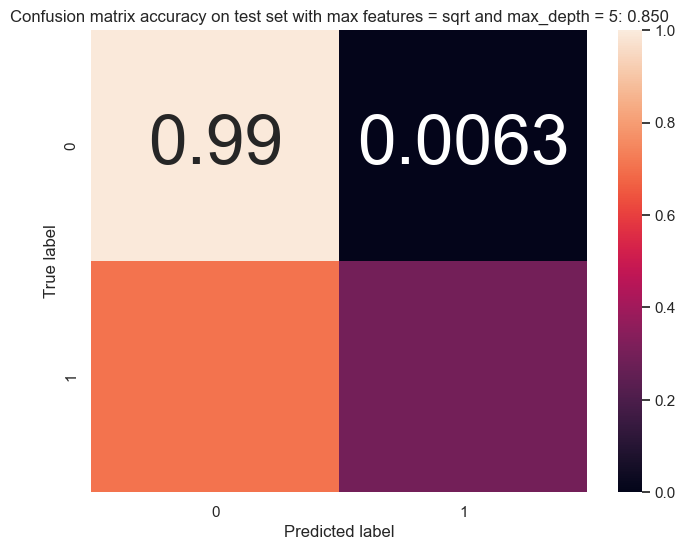

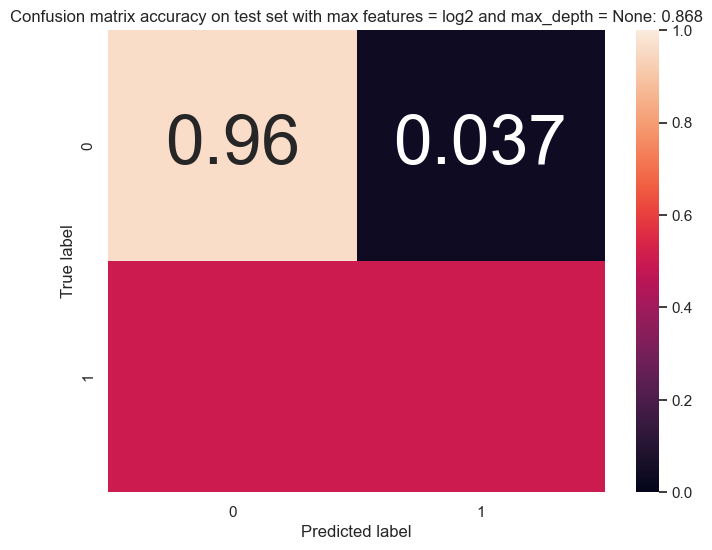

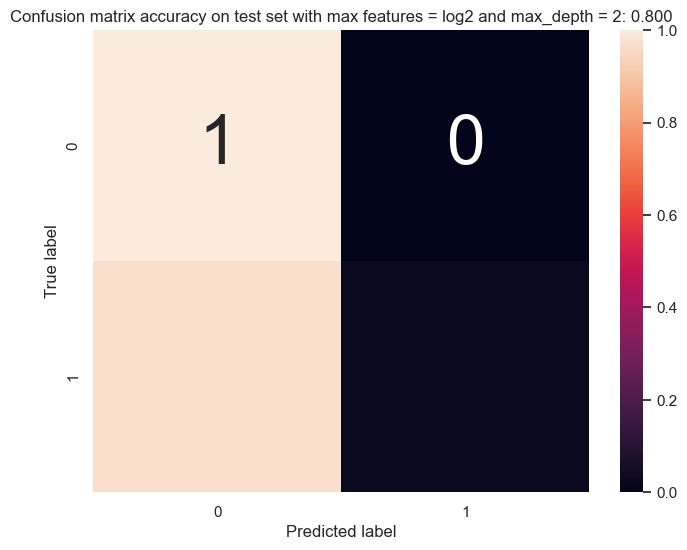

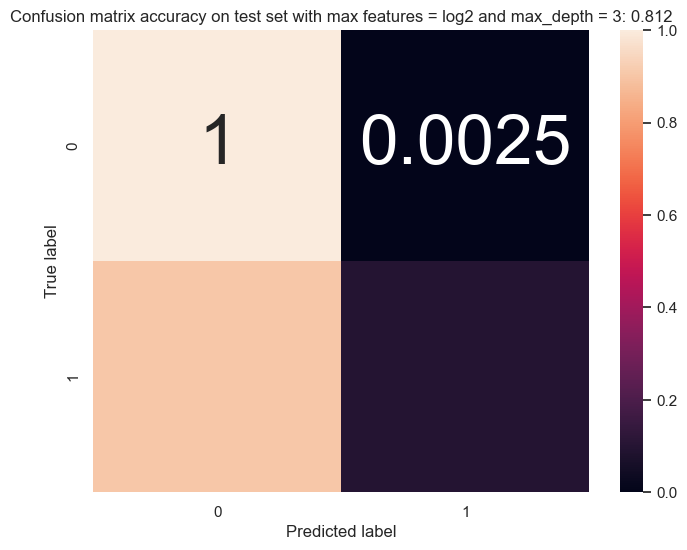

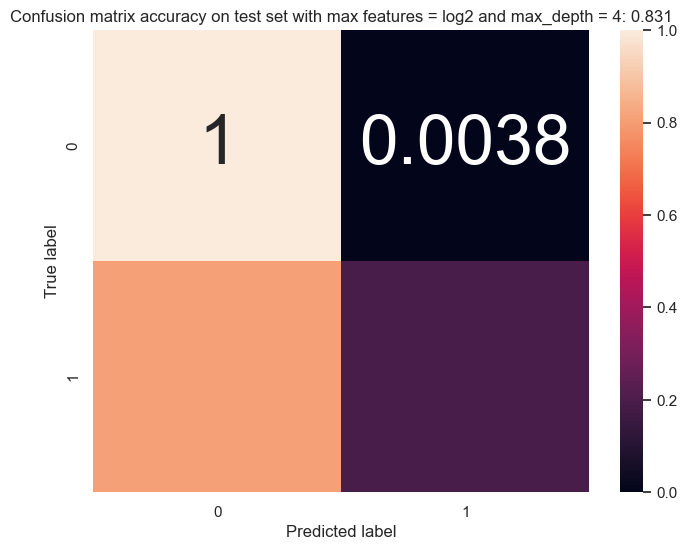

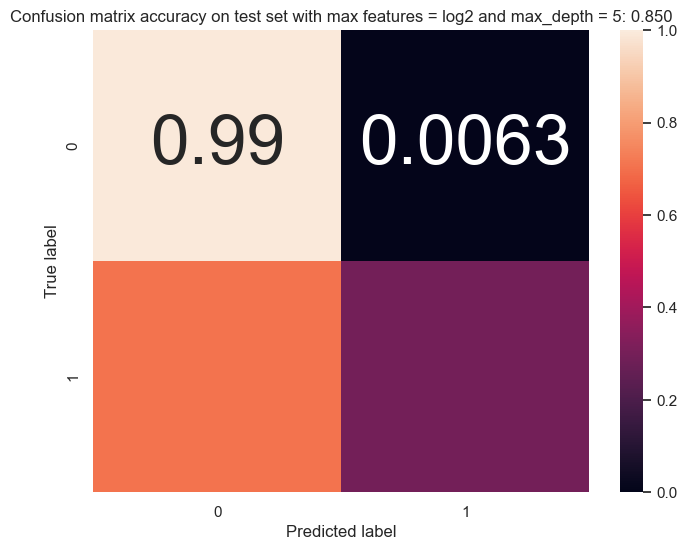

In [50]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): 
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

## XGBoost


In [51]:
 pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [59]:
from sklearn.preprocessing import LabelEncoder
df = pd.DataFrame(X)
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
df = df.applymap(lambda x: 1 if x is True else (0 if x is False else x))
X = df.to_numpy()


In [62]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

y = y.astype(int)

classifier = xgboost.XGBClassifier(tree_method='hist')  # using CPU


params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)

clf.fit(X,y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1;, score=0.852 total time=   1.2s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1;, score=0.850 total time=   1.0s
[CV 3/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1;, score=0.851 total time=   1.0s
[CV 4/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1;, score=0.858 total time=   1.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1;, score=0.843 total time=   1.0s
[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=2, min_child_weight=1;, score=0.863 total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=2, min_child_weight=1;, score=0.864 total time=   0.0s
[CV 3/5] END colsamp

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [63]:
clf.best_params_

{'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.3,
 'colsample_bytree': 0.3}

In [64]:
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

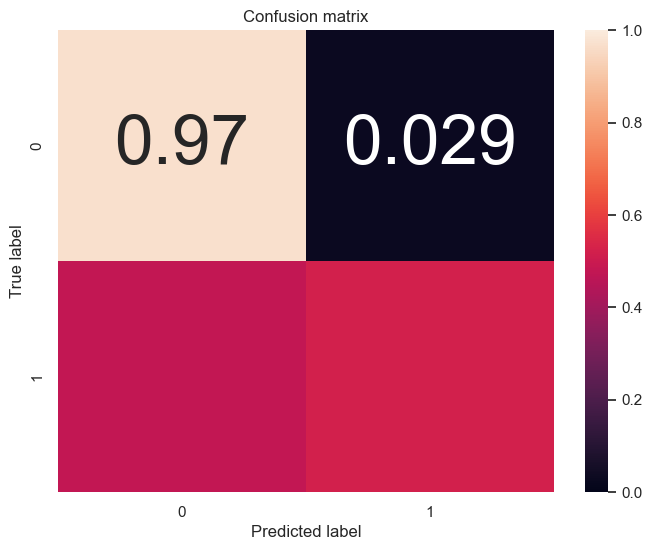

In [66]:
final_model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=5,  monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

final_model.fit(X,y)

pred_xgboost = final_model.predict(X)

cm = confusion_matrix(y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)


### Deploying our model on NEW data 


In [67]:
conn2 = podbc.connect("Driver={ODBC Driver 18 for SQL Server};"
                     "Server=DESKTOP-MMC9PLC\SQLEXPRESS01;"
                     "Database=Churns Predict;"
                     "Trusted_Connection=yes;"
                     "Encrypt=yes;"
                     "TrustServerCertificate=yes;")

unseen_data = pd.read_sql_query('''SELECT * FROM [dbo].[new data]''', conn2)

print(unseen_data.shape)
unseen_data.head()

(3344, 14)


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634638,AP Hargrave,619,France,Female,42,2,0,1,1,1,101348.88,1
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619340,AP Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,4,15701390,AP Boni,699,France,Female,39,1,0,2,0,0,93826.63,0
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0


In [68]:
unseen_data2 = unseen_data[['creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary']]

unseen_data2 = pd.get_dummies(unseen_data2, columns = ['geography', 'gender', 'hascrcard', 'isactivemember'])

scale_vars = ['creditscore','estimatedsalary','balance','age']
unseen_data2[scale_vars] = scaler.fit_transform(unseen_data2[scale_vars])


unseen_data2.head()

,creditscore,age,tenure,balance,numofproducts,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,hascrcard_0,hascrcard_1,isactivemember_0,isactivemember_1
0,0.538,0.342857,2,0.000000,1,0.507077,True,False,False,True,False,False,True,False,True
1,0.516,0.328571,1,0.334031,1,0.563089,False,False,True,True,False,True,False,False,True
2,0.304,0.342857,8,0.636357,3,0.570039,True,False,False,True,False,False,True,True,False
3,0.698,0.300000,1,0.000000,2,0.469437,True,False,False,True,False,True,False,True,False
4,1.000,0.357143,2,0.500246,1,0.395667,False,False,True,True,False,False,True,False,True


In [69]:
pred_xgboost = final_model.predict(unseen_data2.values)
pred_prob_xgboost = final_model.predict_proba(unseen_data2.values)

pred_xgboost

array([0, 0, 1, ..., 0, 0, 0])

In [70]:
pred_prob_xgboost

array([[0.979429, 0.020571],
       [0.974521, 0.025479],
       [0.228213, 0.771787],
       ...,
       [0.977330, 0.022670],
       [0.618112, 0.381888],
       [0.989690, 0.010310]], dtype=float32)

In [71]:
def column(matrix, i):
    return [row[i] for row in matrix]

column(pred_prob_xgboost, 1)

[0.02057111,
 0.025479257,
 0.77178705,
 0.7585277,
 0.026150906,
 0.5503396,
 0.4226233,
 0.8229357,
 0.44199505,
 0.008022054,
 0.49615538,
 0.7311905,
 0.6967323,
 0.6488546,
 0.6619877,
 0.52324235,
 0.01623926,
 0.57836,
 0.017169386,
 0.5663694,
 0.36393604,
 0.7564442,
 0.050094616,
 0.54026514,
 0.02435859,
 0.54026514,
 0.006973592,
 0.52690554,
 0.02276551,
 0.5512147,
 0.88923496,
 0.011865503,
 0.66887784,
 0.61484885,
 0.57836,
 0.06374749,
 0.01144926,
 0.013779997,
 0.010866259,
 0.39839238,
 0.016826404,
 0.030890403,
 0.02057111,
 0.027472176,
 0.03093327,
 0.6037207,
 0.036720607,
 0.036720607,
 0.007470816,
 0.7904186,
 0.70291084,
 0.49694803,
 0.6488546,
 0.023843694,
 0.01623926,
 0.008429573,
 0.01174781,
 0.027851311,
 0.050094616,
 0.0094118165,
 0.014479323,
 0.79644316,
 0.6697107,
 0.010087505,
 0.008278704,
 0.57695043,
 0.039692905,
 0.4544547,
 0.4860814,
 0.030880447,
 0.756083,
 0.014287151,
 0.045961495,
 0.4976132,
 0.4602224,
 0.7699237,
 0.36393604,

In [72]:
output = unseen_data.copy()
output['Predictions - Churn or Not'] = pred_xgboost
output['Predictions - Probability to Churn'] = column(pred_prob_xgboost, 1)
output['Predictions - Churn or Not Desc'] = 'Empty'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 0] = 'Retention'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 1] = 'Churn'
output.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,Predictions - Churn or Not,Predictions - Probability to Churn,Predictions - Churn or Not Desc
0,1,15634638,AP Hargrave,619,France,Female,42,2,0,1,1,1,101348.88,1,0,0.020571,Retention
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0.025479,Retention
2,3,15619340,AP Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1,1,0.771787,Churn
3,4,15701390,AP Boni,699,France,Female,39,1,0,2,0,0,93826.63,0,1,0.758528,Churn
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0,0,0.026151,Retention


### Exporting this data back to a New Table in SQL

In [74]:

from sqlalchemy import create_engine
import urllib

quoted = urllib.parse.quote_plus("Driver={ODBC Driver 18 for SQL Server};"
                     "Server=DESKTOP-MMC9PLC\SQLEXPRESS01;"
                     "Database=Churns Predict;"
                     "Trusted_Connection=yes;"
                     "Encrypt=yes;"
                     "TrustServerCertificate=yes;")

engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

output.to_sql('Churn Predictions Output', schema='dbo', con = engine, if_exists = 'replace')

96